In [86]:
import sys
sys.path.insert(1, "C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/MiDaS")
from torch.utils.data import DataLoader

In [87]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob
from azure.storage.blob import ContainerClient
import io
import ast 
import tarfile
from tqdm import tqdm
from midas.model_loader import default_models, load_model
from run import process

In [88]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [89]:
model_type = "DPT_Hybrid"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\Spark/.cache\torch\hub\intel-isl_MiDaS_master


In [5]:
midas.load_state_dict(torch.load("D:/midasloss2.pt"))
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

In [5]:
midas.to(device)

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): HybridEmbed(
        (backbone): ResNetV2(
          (stem): Sequential(
            (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
            (norm): GroupNormAct(
              32, 64, eps=1e-05, affine=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
          )
          (stages): Sequential(
            (0): ResNetStage(
              (blocks): Sequential(
                (0): Bottleneck(
                  (downsample): DownsampleConv(
                    (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (norm): GroupNormAct(
                      32, 256, eps=1e-05, affine=True
                      (drop): Identity()
                      (act): Identit

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\Spark/.cache\torch\hub\intel-isl_MiDaS_master


In [9]:
pics = glob.glob("D:/Thesis/Data/**/*.png", recursive=True)

In [7]:
folders = ["P000", "P001", "P002", "P003", "P005", "P006", "P007", "P008", "P009", "P0010", "P0011", "P0012", "P0013", "P0014", "P0015", "P030"]

In [8]:
training_list = []

for ind, folder in tqdm(enumerate(folders)):
    pics_left = glob.glob("D:/Thesis/Data/" + folder + "/image_left/*.png")
    pics_right = glob.glob("D:/Thesis/Data/" + folder + "/image_right/*.png")
    for x,y in zip(pics_left, pics_right):
        training_list.append((cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(y), cv2.COLOR_BGR2RGB)))
    if ind == 1:
        break

1it [01:02, 62.55s/it]


In [6]:
loss_fn = torch.nn.MSELoss()
reg_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(midas.parameters(), lr=0.0001)

In [88]:
torch.cuda.empty_cache()

In [24]:
torch.save(midas.state_dict(), "D:/midas.pt")

In [15]:
losses = []
epochs = 2
midas.train(True)
midas.to("cpu")

i = 0 
for epoch in epochs:
    for left, right in tqdm(training_list):   
        optimizer.zero_grad()

        left, right = transform(left).to(device), transform(right)

        out1 = midas(left)
        out2 = midas(right)
        reg1 = torch.full((out1.shape), float(torch.max(out1))).float().to(device)
        reg2 = torch.full((out2.shape), float(torch.max(out2))).float().to(device)

        loss = torch.sqrt(loss_fn(out1, out2)) + reg_loss(out1, reg1) + reg_loss(out2, reg2)

        losses.append(loss)

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print("loss:", loss)
            print("current max:", torch.max(out1))
        i += 1

  0%|          | 1/922 [00:13<3:20:32, 13.06s/it]

loss: tensor(3.1065e+08, grad_fn=<AddBackward0>)
current max: tensor(1734.7933, grad_fn=<MaxBackward1>)


  1%|          | 11/922 [02:28<3:25:41, 13.55s/it]

loss: tensor(8957296., grad_fn=<AddBackward0>)
current max: tensor(387.2464, grad_fn=<MaxBackward1>)


  2%|▏         | 21/922 [04:52<3:36:12, 14.40s/it]

loss: tensor(2318831.5000, grad_fn=<AddBackward0>)
current max: tensor(262.4182, grad_fn=<MaxBackward1>)


  3%|▎         | 31/922 [07:18<3:35:07, 14.49s/it]

loss: tensor(1095722.8750, grad_fn=<AddBackward0>)
current max: tensor(191.2811, grad_fn=<MaxBackward1>)


  4%|▍         | 41/922 [09:43<3:33:25, 14.53s/it]

loss: tensor(1050660.6250, grad_fn=<AddBackward0>)
current max: tensor(155.1896, grad_fn=<MaxBackward1>)


  6%|▌         | 51/922 [12:08<3:30:13, 14.48s/it]

loss: tensor(585215.3125, grad_fn=<AddBackward0>)
current max: tensor(132.0153, grad_fn=<MaxBackward1>)


  6%|▌         | 51/922 [12:22<3:31:27, 14.57s/it]


KeyboardInterrupt: 

# APPROACH 2


In [7]:
# Proportionality constants:

k1 = np.loadtxt("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/k1.csv")
k2 = np.loadtxt("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/k2.csv")

In [70]:
np.where(k1 > 10)
# k1[2096,2291] = 0
# k1[2096,2224] = 0

(array([2096], dtype=int64), array([2224], dtype=int64))

In [8]:
toy1 = Image.open("D:/Thesis/toy_example_SfM/01.jpg")
toy2 = Image.open("D:/Thesis/toy_example_SfM/02.jpg")
toy3 = Image.open("D:/Thesis/toy_example_SfM/03.jpg")

In [9]:
exif_data1 = toy1._getexif()
exif_data2 = toy2._getexif()
exif_data3 = toy3._getexif()

In [10]:
ang1 = ast.literal_eval(exif_data1[270])["MAPAtanAngle"]
ang2 = ast.literal_eval(exif_data2[270])["MAPAtanAngle"]
ang3 = ast.literal_eval(exif_data3[270])["MAPAtanAngle"]

In [11]:
def transform_prediction(depthmap, k, exif1, exif2):
    out = np.ones(depthmap.shape)

    def env_transform(depth, dist, ang):
        # print(type(ang))
        return np.sqrt(depth**2 + dist**2 - 2*depth*dist*np.cos(ang))

    def obj_transform(depth, k):
        if k == 0:
            return depth 
        return k*depth

    ang = float(ast.literal_eval(exif2[270])["MAPAtanAngle"])

    keys = ["MAPLongitude", "MAPLatitude", "MAPAltitude"]
    coords1 = []
    coords2 = []
    for key in keys:
        coords1.append(float(ast.literal_eval(exif1[270])[key]))
        coords2.append(float(ast.literal_eval(exif2[270])[key]))

    cam_dist = np.linalg.norm(np.array(coords2)-np.array(coords1))

    for i in range(depthmap.shape[0]):
        for j in range(depthmap.shape[1]):
            if k[i,j] == 1:
                out[i,j] = env_transform(depthmap[i,j], cam_dist, ang)
            else:
                out[i,j] = obj_transform(depthmap[i,j], k[i,j])

    return out

In [12]:
png1 = cv2.cvtColor(cv2.imread("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/01.png"), cv2.COLOR_BGR2RGB)
png2 = cv2.cvtColor(cv2.imread("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/02.png"), cv2.COLOR_BGR2RGB)
png3 = cv2.cvtColor(cv2.imread("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/03.png"), cv2.COLOR_BGR2RGB)

train_app2 = [[png1, png2, k1, exif_data1, exif_data2], [png1,png3, k2, exif_data1, exif_data3]]

In [13]:
losses = []

midas.train(True)
midas = midas.to("cpu")
for i1, i2, k, exif1, exif2 in (train_app2):
    # optimizer.zero_grad()

    out1 = midas(transform(i1))
    out1 = torch.nn.functional.interpolate(
        out1.unsqueeze(1),
        size=i1.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    out2 = midas(transform(i2))
    out2 = torch.nn.functional.interpolate(
        out2.unsqueeze(1),
        size=i2.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
    out2 = torch.Tensor(transform_prediction(out2.detach().cpu().numpy(), k, exif1, exif2))

    reg1 = torch.full((out1.shape), float(torch.max(out1))).float()
    reg2 = torch.full((out2.shape), float(torch.max(out2))).float()

    # plt.imshow(out2)

    loss = torch.sqrt(loss_fn(out1, out2)) + reg_loss(out1, reg1) + reg_loss(out2, reg2)

    losses.append(loss)
    loss.backward()
    optimizer.step()

c:\Users\Spark\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [14]:
losses

[tensor(6.7702e+12, grad_fn=<AddBackward0>),
 tensor(6.3890e+09, grad_fn=<AddBackward0>)]

In [49]:
from sklearn.preprocessing import normalize

In [83]:
def SILog(gt, pred):
    gt_1 = (gt-np.min(gt))/(np.max(gt)-np.min(gt))
    pred_1 = (pred-np.min(pred))/(np.max(pred)-np.min(pred))

    d = np.empty((gt_1.shape))

    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            if gt[i,j] == 0 or pred[i,j] == 0:
                d[i,j] = 0
            else:
                d[i,j] = np.log(gt_1[i,j]) - np.log(pred_1[i,j])
             

    # d = np.log(gt_1) - np.log(pred_1)

    # print(d)

    n = len(d[d != 0])
    fst = 1/n * (np.sum(d**2)) - 1/(n**2)*(np.sum(d))**2

    return fst

# Load KITTI

In [15]:
eval_list = []
for filename in glob.glob('D:/Thesis/data_depth_selection/depth_selection/val_selection_cropped/image/*'): #assuming gif
    im = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    eval_list.append(im)

In [16]:
ground_truths = []
for filename in glob.glob('D:/Thesis/data_depth_selection/depth_selection/val_selection_cropped/groundtruth_depth/*'): #assuming gif
    im=cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    ground_truths.append(im)

In [90]:
midas.train(False)
midas.to(device)
outputs = []
for img in eval_list:
    with torch.no_grad():
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        prediction = midas(transform(img).to(device))

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

        output = prediction.cpu().numpy()  
        outputs.append(output)

c:\Users\Spark\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [91]:
eval_loss = []
silog_loss = []
for img, label in zip(outputs, ground_truths):
    img = img.flatten().reshape(1,-1)
    label = label.flatten().reshape(1,-1)
    eval_loss.append(np.sqrt(np.mean(img.flatten()-label.flatten())**2))
    silog_loss.append(SILog(label, img))

    break

print(eval_loss)

print(np.mean(eval_loss))

print(np.mean(silog_loss))

[[0.01544601 0.01473674 0.01478389 ... 0.9615007  0.95687157 0.9503649 ]]
[[-4.170405   -4.2174115  -4.2142167  ... -0.03925998 -0.04408609
  -0.05090928]]
[1188.931884765625]
1188.931884765625
-6783809588049.999


In [19]:
png1 = cv2.cvtColor(cv2.imread("D:/data/2023-04-28-00-47-39/images/img_SimpleFlight__0_1682635662733372400.png"), cv2.COLOR_BGR2RGB)
png2 = cv2.cvtColor(cv2.imread("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/topdown_sample.jpg"), cv2.COLOR_BGR2RGB)
png3 = cv2.cvtColor(cv2.imread("C:/Users/Spark/OneDrive/Skrivebord/ML/Thesis/Object_detection/01.png"), cv2.COLOR_BGR2RGB)


In [21]:
out1 = midas(transform(png3).to(device))
out1 = torch.nn.functional.interpolate(
    out1.unsqueeze(1),
    size=png3.shape[:2],
    mode="bicubic",
    align_corners=False,
    ).squeeze()
out1 = out1.detach().cpu().numpy()

In [22]:
out1

array([[ 283.73013,  283.7375 ,  283.5349 , ...,  207.12569,  204.42503,
         204.52275],
       [ 283.754  ,  283.76138,  283.55823, ...,  207.0353 ,  204.33064,
         204.4285 ],
       [ 283.0939 ,  283.10074,  282.91254, ...,  209.54214,  206.94907,
         207.04288],
       ...,
       [1140.9171 , 1140.9128 , 1141.0361 , ..., 1124.9111 , 1124.7753 ,
        1124.7805 ],
       [1141.2239 , 1141.2191 , 1141.3596 , ..., 1125.2838 , 1125.1445 ,
        1125.1499 ],
       [1141.2129 , 1141.2081 , 1141.3481 , ..., 1125.2705 , 1125.1312 ,
        1125.1366 ]], dtype=float32)

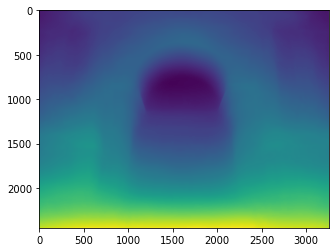

In [23]:
plt.imshow(out1)